In this notebook, we will present how to classify flower images by using transfer learning from a pre-trained network. 

A network model that has been saved and earlier trained using a sizable dataset is known as a **pre-trained model.**

The concept behind **transfer learning** for image classification is that if we use a model that was trained on a really big, representative dataset, this model can serve as our basic model for categorising images. This allows to save a lot of training time by utilizing the feature maps.


Here, we're gonna test two approaches:
1. **feature extraction**: We extract significant features from fresh data using representations learned by a network that has already undergone training. Simply adding a new classifier will allow us to use the feature maps that have already been learned for the dataset and will be trained on top of the pretrained model. We do not need to restart this trained network, of course. There are already features in the basic convolutional network that are generally helpful for classifying images. It should be noted that the pretrained model's ultimate classification component only considers the initial classification.

2. **fine tuning** : This approach involves unfreezing a few of the top layers of the previously frozen model and jointly training the new top layer (to identify our particular datasets) and these final layers of the frozen model. We take this action because the first convolution layers of the base model only extract fundamental features (edges, vertical/horizontal lines, etc.), while the final layers of the base model extract top-level feature maps. By fine-tuning the base model's top feature representation, we can increase their specificity for our classification job.

[ **I ) Introduction**](#content1)
- MobileNetV2

[ **II ) Data**](#content2)
- 2.1 Load & explore data
- 2.2 Split training and validation set

[ **III ) CNN model**](#content3)
- 3.1 About the optimizer and learning rate
- 3.2 Define the model
- 3.3 Data augmentation
- 3.4 Feature extraction
- 3.5 Fine tuning

[ **IV ) Model evaluation **](#content4)
- Confusion matrix 
- Prediction vizualisations

[ **V ) Conclusion **](#content5)

In [1]:
# import stuff 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from IPython.display import Image, display
import os

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as prepro_res50
from tensorflow.keras.applications.vgg19 import preprocess_input as prepro_vgg19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D

In [2]:
# load the backend
from keras import backend as K

# prevent Tensorflow memory leakage
K.clear_session()

<a id="content1"></a>
## I) Introduction

In this notebook, we'll make use of a much complex architecture with the MobileNetV2 model. It has been developed in 2018, MobileNetV2 is a significant improvement over MobileNetV1 and pushes the state of the art for mobile visual recognition including classification, object detection and  segmentation. If you're interested, you can find more details in the [release paper](https://arxiv.org/abs/1801.04381).

<a id="content2"></a>
## II) Data

### 2.1 - Load & explore data

In [3]:
path_data = r'D:\T431 - George Brown\DL Math 2\Flower_Classication_using_Transfer_Learning\flowers'
print(os.listdir(path_data))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [4]:
from os.path import join

img_folders = [join(path_data, folder) for folder in os.listdir(path_data)]
list(img_folders)

['D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\daisy',
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\dandelion',
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\rose',
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\sunflower',
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\tulip']

In [5]:
data_dir = r'D:\T431 - George Brown\DL Math 2\Flower_Classication_using_Transfer_Learning\flowers'

data = load_files(data_dir, random_state=28, shuffle=True)
X = np.array(data['filenames'])    # files location of each flower
y = np.array(data['target'])       # target label of each flower
labels = np.array(data['target_names'])

# remove eventual .pyc or .py files
pyc_file = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for pos in pyc_file:
    X = np.delete(X, pos)
    y = np.delete(y, pos)
    
print(f'Data files - {X}')
print(f'Target labels - {y}')   # numbers are corresponding to class label, 
                               # we have to change them to a vector of 5 elements
print(f'Name labels - {labels}')
print(f'Number of training files : {X.shape[0]}')

Data files - ['D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\rose\\2265390547_2409007cef_n.jpg'
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\dandelion\\34689593326_0fd3fbc38a_n.jpg'
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\tulip\\10094729603_eeca3f2cb6.jpg'
 ...
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\dandelion\\5598845098_13e8e9460f.jpg'
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\tulip\\5757091018_cdfd79dfa6_m.jpg'
 'D:\\T431 - George Brown\\DL Math 2\\Flower_Classication_using_Transfer_Learning\\flowers\\dandelion\\34537877932_f9a3476a4d_n.jpg']
Target labels - [2 1 4 ... 1 4 1]
Name labels - ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']
Number of training files : 4317


In [6]:
# Flower species number
df = pd.DataFrame({'species': y})
print(df.shape)
df.head()

(4317, 1)


,species
0,2
1,1
2,4
3,2
4,4


In [7]:
# associate names to species number
df['flower'] = df['species'].astype('category')
df['flower'].cat.categories = labels
df.head()

C:\Users\pinku\AppData\Local\Temp\ipykernel_10052\1180994331.py:3: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  df['flower'].cat.categories = labels


,species,flower
0,2,rose
1,1,dandelion
2,4,tulip
3,2,rose
4,4,tulip


Let's check how many of each species of flowers are present.

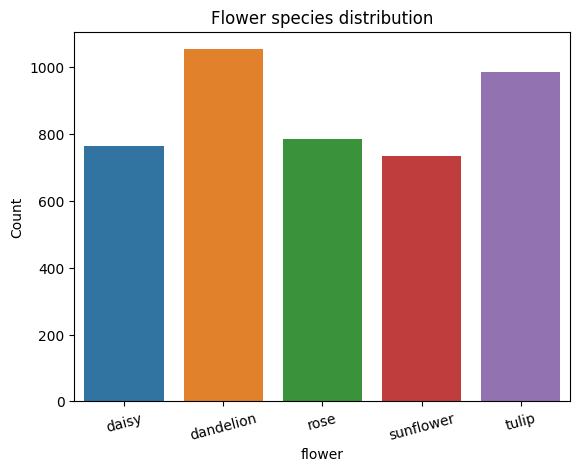

In [8]:
fig, ax = plt.subplots()
ax = sns.countplot(x="flower", data=df)
ax.set(ylabel='Count', title='Flower species distribution')
ax.tick_params(axis='x', rotation=15)

Now, we're gonna load the different images and transform them into numpy arrays.

In [9]:
image_size = 224     # standard value for Transfer learning usecase (MobileNet, ResNet50, VGG16, VGG19)

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]   # load image
    img_array = np.array([img_to_array(img) for img in imgs])   # image to array 
    return(img_array)

X = np.array(read_and_prep_images(X))
print(X.shape)  # (4323, 224, 224, 3) = (num_images, height_size, width_size, depth=RGB)

(4317, 224, 224, 3)


In [10]:
# Let's have a look at 6 randomly picked flowers.

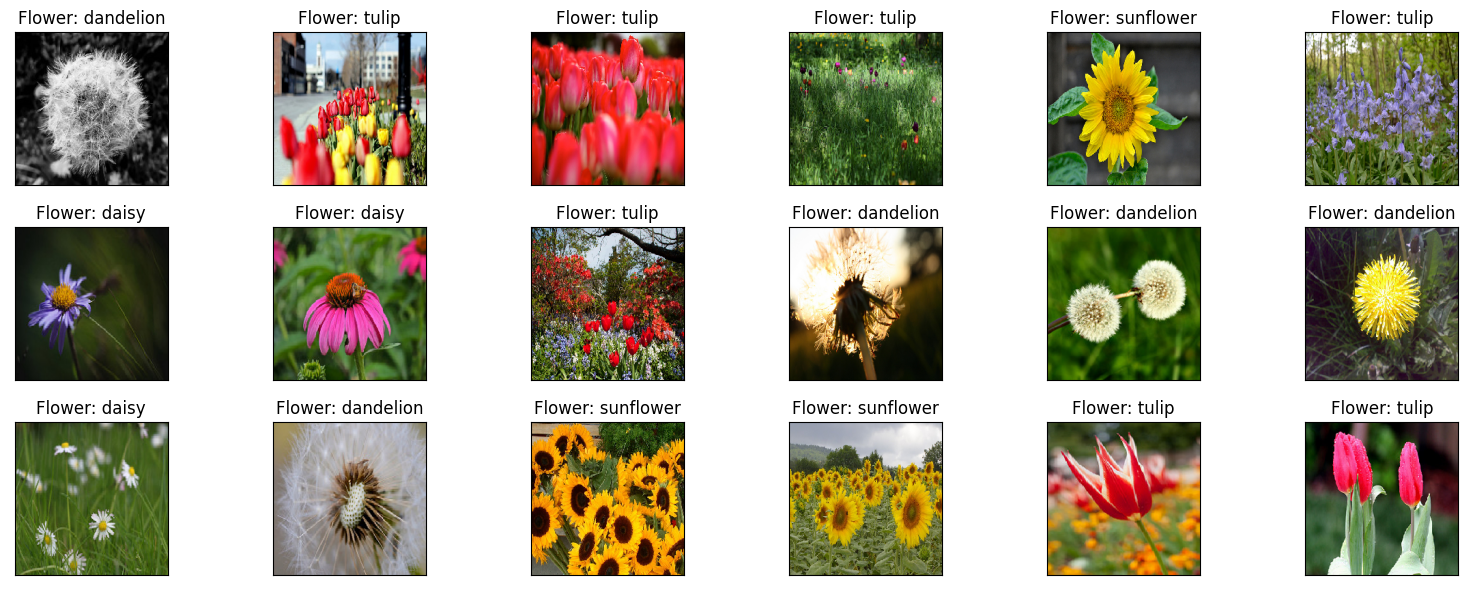

In [11]:
N = 18  # flowers to display
fig, axes = plt.subplots(3, 6, figsize=(16,6))
for ax, j in zip(axes.flat, np.random.randint(0, len(X), N)):    
    ax.imshow(X[j].astype(np.uint8))
    ax.set(title=f'Flower: {labels[y[j]]}', xticks=[], yticks=[])
fig.tight_layout()

### 2.2 - Label encoding

In [12]:
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes} --> {labels}')

Number of classes: 5 --> ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


Labels are the 5 species number (from 0 to 4). Thus, we need to encode these labels to one-hot vectors. For instance, an image of a sunflower should have a label 3 and a corresponding **y** = [0,0,0,1,0].

In [13]:
y = to_categorical(y, num_classes)
print(y.shape)

(4317, 5)


### 2.3 - Split training and validation set

Here, we're gonna split our dataset into a training, a validation and a testing one. This ensures that there are no bias: the model is trained on images with known labels, then we test our model accuracy on the validation dataset on images that our model did not see before. Finally, we compute the accuracy on the test dataset.

In [14]:
#train, validation and test from the train dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, 
                                                test_size=0.25, random_state=28)

Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5,
                                            shuffle=True, random_state=28)
print(f'Train dataset: {Xtrain.shape[0]}')
print(f'Validation dataset: {Xval.shape[0]}')
print(f'Test dataset: {Xtest.shape[0]}')

Train dataset: 3237
Validation dataset: 540
Test dataset: 540


In [15]:
# release memory
del X

In [16]:
del y

<a id="content3"></a>
## III) CNN model

### 3.1 About the optimizer and learning rate

When our model will be built, we need to specify an accuracy function, a loss function and an optimisation algorithm.

The accuracy function is used to evaluate the performance of the model.

The loss function is used to measure how the model performs on data with known labels. It tells us how poorly the model performs in a supersised system. For multi-label classification, we make use of a specific loss function called as *categorical_crossentropy* (similar to cross-entropy in maths).

Finally, the optimizer function is used in order to minize the loss function by changing model parameters (weighs values, filters kernel values etc.). 

For this classification problem, we choose the `RMSprop` optimizer which is very efficient and commonly used (more details on the [optimizers on Keras here](https://keras.io/optimizers/)).

Since deep networks can take quiet a time for the optimizer to converge, we're gonna use an annealing method of the learning rate (*LR*).

The *LR* is basically the step by which the optimizer is 'walking'. A hight *LR* correspond to big steps and thus the convergence is faster. However, in that case the sampling is not really efficient since the optimizer do not fall especially in the right minima.

At the opposite, have a low *LR* means that the optimizer will probably find the right local minima but it will take a lot of time. 

The idea here is to start from a low value but not so low and then decrease the *LR* along the training to reach efficiently the global minimum of the loss function. Using the `ReduceLROnPlateau` method , we are able to choose to reduce the *LR* by a coefficient (here 75%) if the accuracy has not improved after a number of epochs (here 3).

<br>

In addition, we use the `EarlyStopping` method to control the training time: if the accuracy has not improved after 5 epochs we stop.

Finally we make use of the `ModelCheckpoint` which is useful for monitoring the best found weights during the training.

### 3.2 Define the model

For now, we're doing feature extraction i.e. we freeze the convolutional base (MobileNet). Then, we add a classifier on top of it and train this top-level classifier.

In [17]:
# Load the VGG19 model without the final layers (include_top=False)
img_shape = (image_size, image_size, 3)

print('Loading MobileNetV2 ...')
base_model = MobileNetV2(input_shape=img_shape,
                   include_top=False,
                   weights='imagenet')
print('MobileNetV2 loaded')

base_model.trainable = False
    
#base_model.summary()

Loading MobileNetV2 ...
MobileNetV2 loaded


In [18]:
base_model.output_shape

(None, 7, 7, 1280)

Now, we need to generate predictions from the block of features, average over the spatial locations, using a `GlobalAveragePooling2D` layer to convert the features to a single 1280-element vector per image. Finally, we'll some regular `Dense` layer with a final one with 5 units corresponding to each species of flower.

In [19]:
model = Sequential([base_model,
                    GlobalAveragePooling2D(), 
                    Dense(num_classes, activation='softmax')
                   ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Note that only ~ 6000 parameters will be trained, the other ~2.2M from the MobileNetV2 model were already trained.

In [20]:
# callbacks 
weight_path = '{}_best_model.h5'.format('flower')
checkpointer = ModelCheckpoint(weight_path,
                               monitor='val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto',
                               save_weights_only=True)

# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00001)
    
# early stop if not improvement of accuracy after 5 epochs
early = EarlyStopping(patience=6, 
                      verbose=1) 
    
callbacks = [checkpointer, learning_rate_reduction] #, early]

# Optimizer
opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
# Compilation
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### 3.3 - Data augmentation

A useful trick to ovoid any overfitting is to use *data augmentation*. What is that? Well, the idea is to add artificially data into our dataset. But of course not any data, we alter the dataset with tiny transformations to reproduce very similar images. 

For instance, we rotate of a few degree an image, we de-center it or we zoom in or out a little bit. These common augmentation techniques are horizontal/vertical flips, rotations, translations, rescaling, random crops, adjust brightness and more.

Thanks to these transformations, we can get bigger dataset (x2, x3 in size) and then train our model in a much robust way.

In [21]:
image_size = 224
batch_size = 32
path = r'flowers'

#train_gen = train_aug.flow(Xtrain, ytrain, batch_size=batch_size)
# The validation data must not have data augmentation
#valid_gen = valid_no_aug.flow(Xval, yval, batch_size=batch_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,           # rescale pixel values [0,255] to [0,1]
        horizontal_flip=True,     # random horizontal flip
        width_shift_range=0.2,    # random shift images horizontally (fraction of total width)
        height_shift_range=0.2,   # random shift images vertically (fraction of total height)
        zoom_range=0.2)           # random zoom image
        #rotation_range=20,       # random rotation
        #shear_range=0.2)         # shear transfo
        #validation_split=0.2)    # splitting train / test datasets

test_datagen = ImageDataGenerator(
        rescale=1./255)
        #validation_split=0.2)

train_gen = train_datagen.flow(
        Xtrain, ytrain, 
        batch_size=batch_size,
        shuffle=False)              # already applied

valid_gen = test_datagen.flow(
        Xval, yval,
        batch_size=batch_size,
        shuffle=False)   

### 3.4 Feature extraction

In [22]:
batch_size = 32
epochs_0 = 10
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

Epoch 1/10
101/101 [==============================] - ETA: 0s - loss: 0.8242 - accuracy: 0.6927
Epoch 1: val_accuracy improved from -inf to 0.80273, saving model to flower_best_model.h5
101/101 [==============================] - 39s 293ms/step - loss: 0.8242 - accuracy: 0.6927 - val_loss: 0.5514 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.8365
Epoch 2: val_accuracy improved from 0.80273 to 0.81250, saving model to flower_best_model.h5
101/101 [==============================] - 27s 266ms/step - loss: 0.4731 - accuracy: 0.8365 - val_loss: 0.5507 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8546
Epoch 3: val_accuracy improved from 0.81250 to 0.84570, saving model to flower_best_model.h5
101/101 [==============================] - 26s 258ms/step - loss: 0.4072 - accuracy: 0.8546 - val_loss: 0.4689 - val_accuracy: 0.8457 - lr: 0.

In [23]:
def plot_history(history, loss_max=5):
    """
    Check loss and accuracy evolution.
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

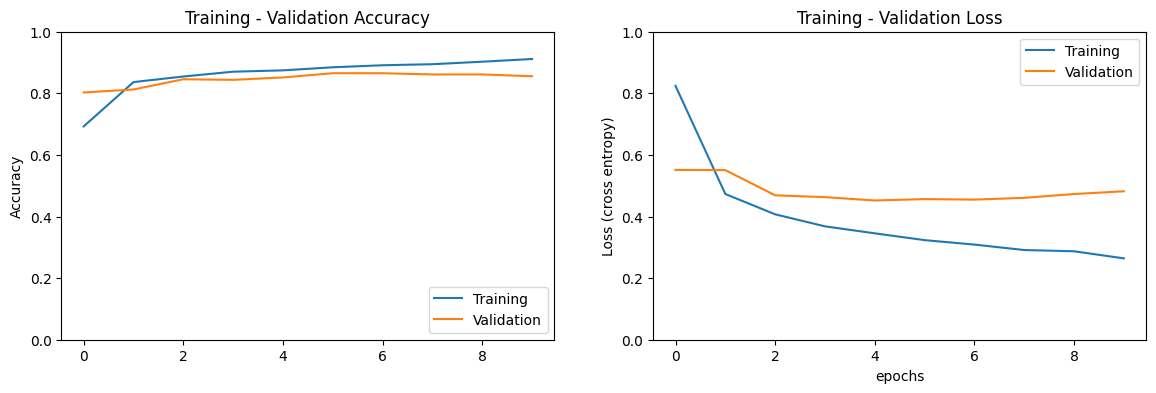

In [24]:
plot_history(history, loss_max=1)

In [31]:
# Generator for test dataset
datagen = ImageDataGenerator(
        rescale=1./255)

eval_datagen = datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      # since shuffle was already during splitting into train, valid, test

# Evaluation on the test dataset
loss, acc = model.evaluate(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

Test loss: 0.51
Test accuracy: 84.81%


### 3.5 Fine tuning

It is now time for the fine tuning of our model: we're gonna unfreeze some of the top layers of the base model and train all those and the top layer classifier.

In [32]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 154


In [33]:
# Fine-tune from this layer onwards
fine_tuning = 100

# Freeze all the layers before fine_tuned_ind
for layer in base_model.layers[:fine_tuning]:
    layer.trainable =  False

In [35]:
# Load best weights
# model.load_weights(weight_path)

# Finer learning rate now
opt = RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    
# Compilation
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 1,867,845
Non-trainable params: 396,544
_________________________________________________________________


Continue training the model

In [38]:
fine_tuned_epochs = 10
total_epochs = epochs_0 + fine_tuned_epochs

history_fined = model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

Epoch 10/20
101/101 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.8980
Epoch 10: val_accuracy did not improve from 0.86523
101/101 [==============================] - 39s 345ms/step - loss: 0.3006 - accuracy: 0.8980 - val_loss: 0.5133 - val_accuracy: 0.8652 - lr: 1.0000e-04
Epoch 11/20
101/101 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9463
Epoch 11: val_accuracy improved from 0.86523 to 0.87109, saving model to flower_best_model.h5
101/101 [==============================] - 34s 335ms/step - loss: 0.1524 - accuracy: 0.9463 - val_loss: 0.5359 - val_accuracy: 0.8711 - lr: 1.0000e-04
Epoch 12/20
101/101 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9704
Epoch 12: val_accuracy improved from 0.87109 to 0.88086, saving model to flower_best_model.h5
101/101 [==============================] - 34s 338ms/step - loss: 0.0878 - accuracy: 0.9704 - val_loss: 0.5252 - val_accuracy: 0.8809 - lr: 1.0000e-04
Epoch 13/20
101/

In [39]:
def plot_history_fined(history, history_fined, initial_epochs=epochs_0, loss_max=1):
    """
    Check loss and accuracy evolution after fine tuning
    """
    
    acc = history.history['accuracy'][:epochs_0]
    acc += history_fined.history['accuracy']
    val_acc = history.history['val_accuracy'][:epochs_0]
    val_acc += history_fined.history['val_accuracy']
    
    loss = history.history['loss'][:epochs_0]
    loss += history_fined.history['loss']
    val_loss = history.history['val_loss'][:epochs_0]
    val_loss += history_fined.history['val_loss']
  
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='fine-tuning', ls='--')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([0.4,1.005]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.plot([initial_epochs-1,initial_epochs-1],
             [0,1] , label='fine-tuning', ls='--')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

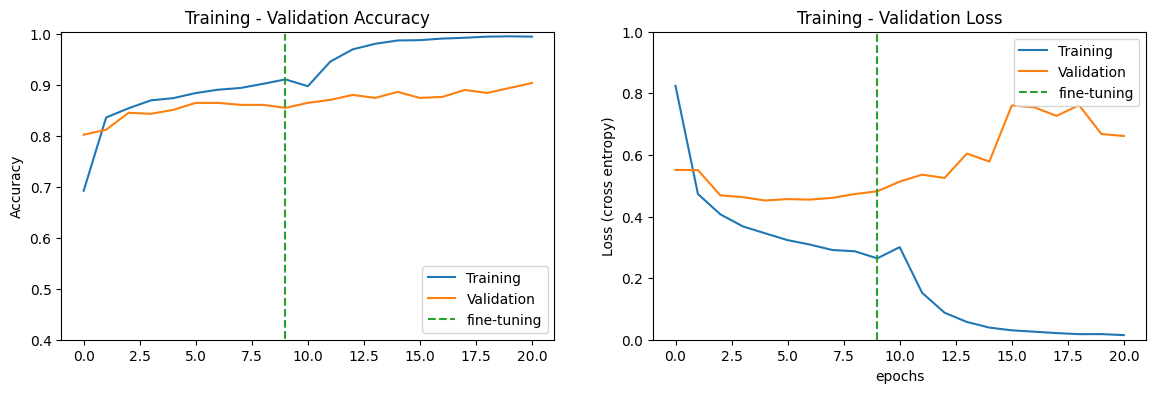

In [40]:
plot_history_fined(history, history_fined)

Great ! We can really see that fine-tuning is working and improve the accuracy of our model. We note also that the validation loss tends to increase a bit a the end: to prevent an eventual overfitting situation, we could add the `EarlyStopping` function in the callbacks during the training.

<a id="content4"></a>
## IV) Model evaluation

In [41]:
# Evaluation on the test dataset
loss, acc = model.evaluate(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

Test loss: 0.52
Test accuracy: 90.74%


Indeed we have now an 90% accuracy on the test dataset (compared to 84% before fine tuning) ! 

### Confusion matrix

17/17 [==============================] - 2s 71ms/step
              precision    recall  f1-score   support

           0       0.96      0.86      0.90        99
           1       0.90      0.95      0.92       128
           2       0.89      0.87      0.88        99
           3       0.93      0.93      0.93        88
           4       0.88      0.92      0.90       126

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.91      0.91      0.91       540



Text(0.5, 36.72222222222221, 'Predicted label')

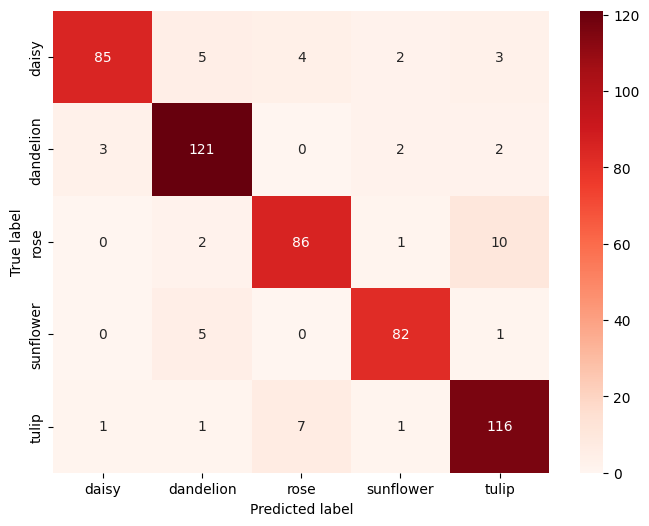

In [42]:
import seaborn as sns
from sklearn import metrics

pred = model.predict(eval_datagen, verbose=1)

# get most likely class
y_pred = pred.argmax(axis=1)
y_true = ytest.argmax(axis=1)

print(metrics.classification_report(y_true, y_pred))

# confusion matrix
mat = metrics.confusion_matrix(y_true, y_pred)
df_mat = pd.DataFrame(mat, index=labels, columns=labels)
plt.figure(figsize=(8,6))
sns.heatmap(df_mat, annot=True, fmt='d', cmap=plt.cm.Reds)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Prediction vizualisations

let's have a look at some predictions !

Text(0.5, 0.98, 'Predicted flowers; Incorrect Labels in Red')

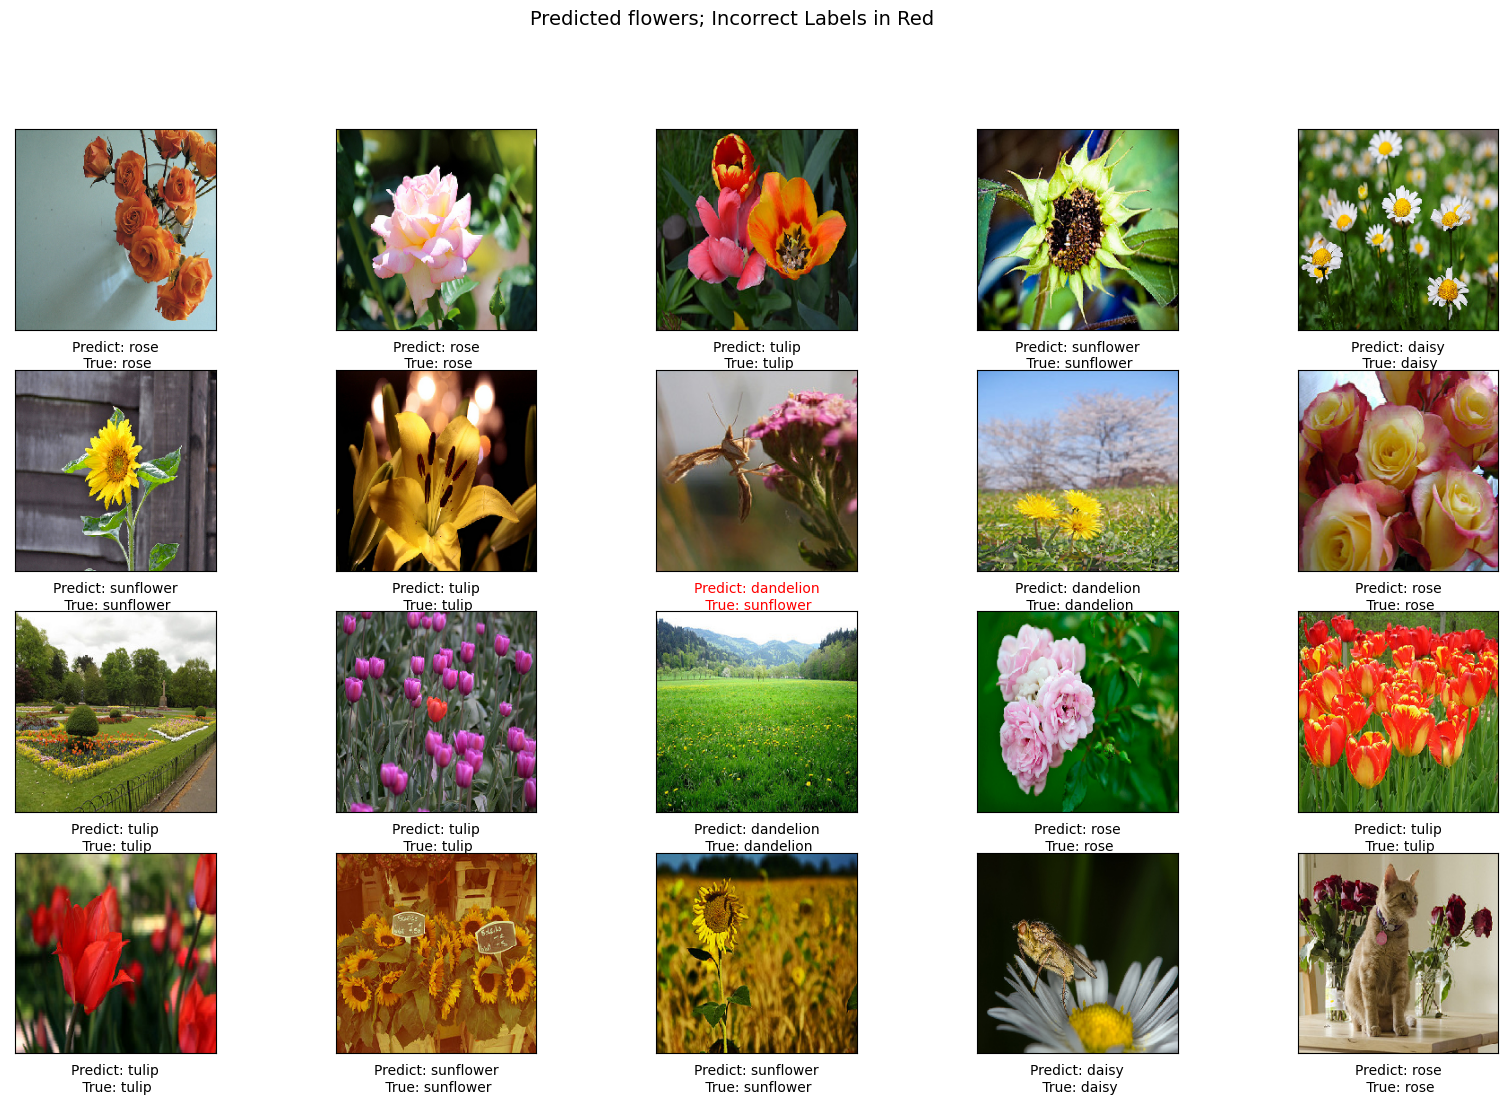

In [43]:
N = 20  # flowers to display
fig, axes = plt.subplots(4, 5, figsize=(20,12))
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].astype(np.uint8))
    ax.set(xticks=[], yticks=[])
    true = y_true[i]
    prediction = y_pred[i]   
    ax.set_xlabel(f'Predict: {labels[prediction]}\n True: {labels[true]}', 
                  color='black' if true == prediction else 'red')

#fig.tight_layout()
fig.suptitle('Predicted flowers; Incorrect Labels in Red', size=14)

<a id="content5"></a>
## Conclusion

We can note the improvement of the model predictions by doing some fine-tuning. Of course, we can complexify the model by playing with the hyperparameters and/or adding other layers on top of the top-less MobileNetV2 base model such as several `Dense` layers with some `Dropout` or `BatchNormalization` ones between (to avoid overfitting). Feel free to test some different architectures to improve the accuracy of the predictions.

It will be interesting also to compare this fine-tuning method with others models such as VGG16, VGG19, ResNet50 etc.



